In [1]:
# 경고(warning) 비표시
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

# 제4장 고객의 행동을 예측하는 테크닉 10

### 테크닉 31 : 데이터를 읽어들이고 확인하자

In [2]:
use_log = pd.read_csv('use_log.csv')
use_log.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### 테크닉 32 : 클러스터링으로 회원을 그룹화하자

In [4]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# 데이터를 표준화하는 것을 말함
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

In [8]:
pd.DataFrame(customer_clustering_sc)

,0,1,2,3,4
0,-0.281206,-0.133676,0.081177,-0.533620,2.034025
1,-0.140545,-0.133676,-0.379928,-0.021149,2.034025
2,-0.421867,-0.133676,-0.841034,-0.021149,2.034025
3,-0.281206,-0.400393,-0.379928,-0.533620,2.034025
4,-0.796964,-0.667109,-0.841034,-1.046090,2.034025
...,...,...,...,...,...
4187,1.500501,1.466622,0.081177,2.541203,-1.288115
4188,2.625790,2.533488,1.003389,3.566144,-1.288115
4189,1.500501,1.466622,0.081177,2.541203,-1.288115
4190,3.188435,3.066921,1.464494,4.078615,-1.288115


In [16]:
# customer_clustering_sc데이터를 넣어 클러스터링
# kmeans 모델을 정의한다.
kmeans = KMeans(n_clusters=4, random_state=0)
# 클러스터링 모델을 구축한다.
clusters = kmeans.fit(customer_clustering_sc)

In [17]:
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"])

0       1
1       1
2       1
3       1
4       1
       ..
4187    0
4188    0
4189    0
4190    0
4191    0
Name: cluster, Length: 4192, dtype: int32


In [18]:
customer_clustering.rename(columns={'mean':'월평균값', 'median':'월중앙값', 'max':'월최댓값', 'min':'월최솟값', 'membership_period':'회원기간'}, inplace=True)
customer_clustering

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1
...,...,...,...,...,...,...
4187,8.000000,8.0,8,8,1,0
4188,10.000000,10.0,10,10,1,0
4189,8.000000,8.0,8,8,1,0
4190,11.000000,11.0,11,11,1,0


### 테크닉 33 : 클러스터링 결과를 분석하자

In [21]:
customer_clustering.groupby('cluster').count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [22]:
customer_clustering.groupby('cluster').mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


### 테크닉 34 : 클러스터링 결과를 가시화하자

In [25]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)

In [30]:
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering['cluster']

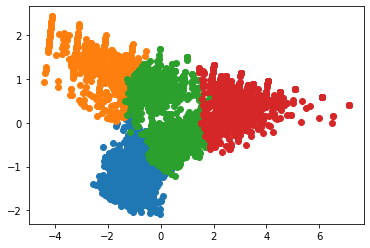

In [31]:
import matplotlib.pyplot as plt

for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster'] == i]
    plt.scatter(tmp[0], tmp[1])

### 테크닉 35 : 클러스터링 결과를 바탕으로 탈퇴회원의 경향을 파악하자

In [32]:
customer_clustering.head()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


In [36]:
x = pd.concat([customer,customer_clustering] , axis=1)
x.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


### 테크닉 36 : 다음달의 이용횟수 예측을 위해 테이터를 준비하자

### 테크닉 37 : 특징이 되는 변수를 추가하자

### 테크닉 38 : 다음달 이용횟수를 예측하는 모델을 구축하자

### 테크닉 39 : 모델에 기여하는 변수를 확인하자

### 테크닉 40 : 다음달의 이용횟수를 예측하자